In [10]:
import os
import sys

import importlib
import conversion_utils
importlib.reload(conversion_utils)
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as skio
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from skimage import data, morphology, feature, filters
from skimage.future import graph
from skimage.color import label2rgb
import networkx as nx
from scipy.ndimage.interpolation import shift
from skimage.morphology import closing, opening, square, remove_small_holes, remove_small_objects

In [4]:
file_dir = os.path.join(os.getcwd(), "assets", "niftynet_raw_images")
print("Your files are/should be in ", file_dir)
patients = [int(x) for x in os.listdir(file_dir) if len(os.listdir(os.path.join(file_dir, str(x)))) > 0]
patients.sort()
print("\n\nYour available patient IDs are ", patients)

Your files are/should be in  /Users/eiofinova/niftynet/assets/niftynet_raw_images


Your available patient IDs are  [1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 64, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

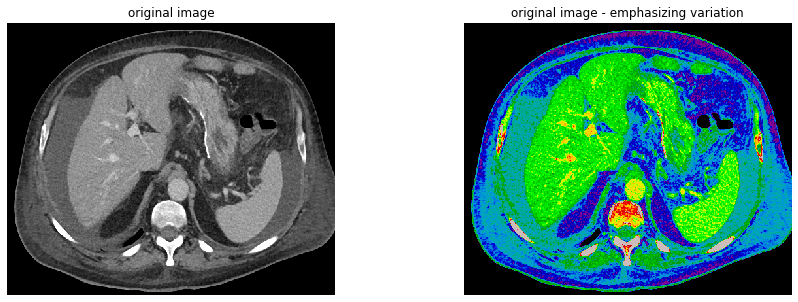

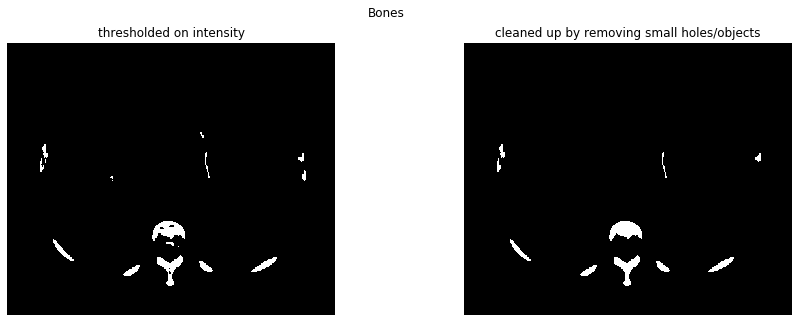

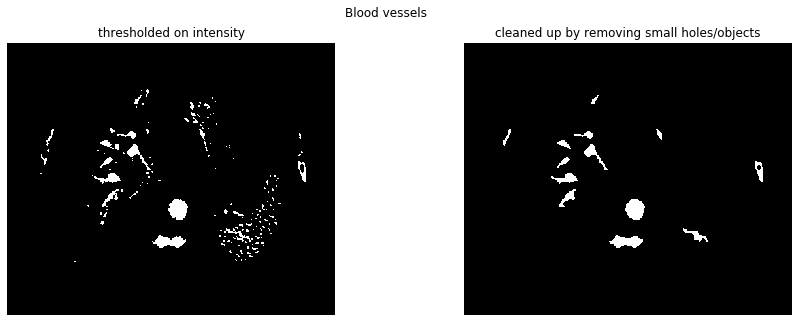

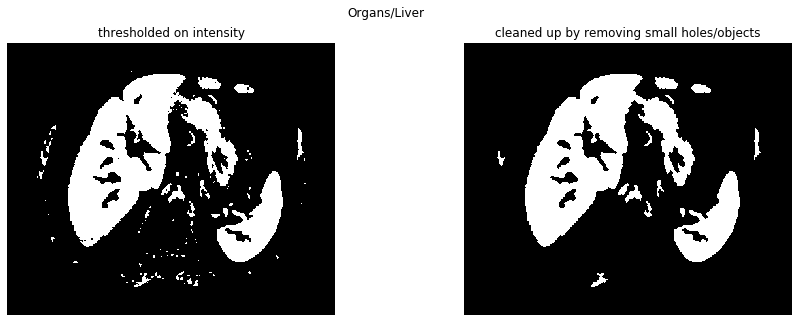

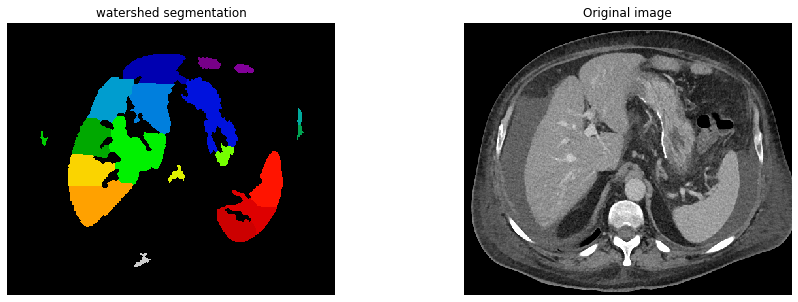

In [11]:
# Set these parameters
patient = 2
slice_idx = 169

# Optionally, also set these.
bones_thresh = [200, 2, 64]
blood_vessels_thresh = [160, 5, 64]
liver_thresh = [125, 1, 64]

# Probably better not to mess with anything below this.
img_path = "assets/niftynet_raw_images/%d/%d.png" % (patient, slice_idx)
img = skio.imread(img_path)

dicom_utils.show_scan(img)
mask = dicom_utils.partition_at_threshold(img, *bones_thresh, title="Bones")
img = img * (1 - mask)
mask = dicom_utils.partition_at_threshold(img, *blood_vessels_thresh, title="Blood vessels")
img = img * (1 - mask)
liver = dicom_utils.partition_at_threshold(img, *liver_thresh, title = "Organs/Liver")
dicom_utils.label_image(liver, orig=skio.imread(img_path))

In [7]:
def guess_bounds_1(regions_map, prev_regions_map):
    labels = np.nonzero(np.bincount(regions_map.flatten()))[0]
    prev_labels = np.nonzero(np.bincount(prev_regions_map.flatten()))[0]
    print("labels", labels, prev_labels)
    newliver = regions_map.copy()
    #ii = np.nonzero(bincounts)[0]
    label_idx = len(labels) + 1
    
    # Label all the new regions of the liver
    for rs0 in range(1, len(labels)):
        for rs1 in range(1, len(prev_labels)):
            union = regions_map == rs0
            #print(sum(union))
            union[prev_regions_map != rs1] = 0
            if union.sum() > 0:
                #print("newlabel", sum(union))
                newliver[union] = label_idx
                # this makes really cool pictures
                # livers[i][union] = len(regions[i]) + label_idx
                label_idx += 1
        liver_mask = newliver > 0
        #print(len(regions[i]))
        liver_mask[newliver >= len(labels)] = False
        liver_mask2 = label(liver_mask)
        # Create separate namespace for the new areas.
        newliver[liver_mask] = liver_mask2[liver_mask] + 100
        bincounts = np.bincount(newliver.flatten())
        ii = np.nonzero(bincounts)[0]
        adj = graph.RAG(newliver)
        mult_neighbors = []
        #print("hello", adj.nodes, [e for e in adj.edges if e[0] > 100 or e[1] > 100])
        for node in adj.nodes:
            if node > 100:
                edges = [edge for edge in adj.edges(node) if edge[0] != 0 and edge[1] != 0]
                if len(edges) == 1:
                    if edges[0][0] == node:
                        #print(edges[0][1])
                        #newliver[newliver == node] = edges[0][1]
                        pass
                    else:
                        #print(edges[0][1])
                        #newliver[newliver == node] = edges[0][0]
                        pass
                else:
                    mult_neighbors.append((node, [x for edge in edges for x in edge if x != node]))
        for region, neighbors in mult_neighbors:
            dists = []
            # Find distances to all the existing things.
            for neighbor in neighbors:
                mymask = np.ones_like(newliver)
                mymask[newliver == neighbor] = 0
                #print("myshape1", mymask.shape)
                mymask = ndi.distance_transform_edt(mymask)
                #print("myshape", mymask.shape)
                dists.append((neighbor, mymask))
            for io in range(newliver.shape[0]):
                for jo in range(newliver.shape[1]):
                    if newliver[io][jo] == region:
                        closest_region = -1
                        closest_distance = 10000
                        for n, d in dists:
                            #print(d.shape)
                            if d[io][jo] < closest_distance:
                                closest_distance = d[io][jo]
                                closest_region = n
                        if closest_region < 0:
                            continue
                        #loz[io][jo] = closest_region
    return newliver

In [486]:
]]]]]# Find the liver on one good slice
# From there:
# For each thing that touches the liver and also touches something else:
# Estimate how much the liver and the other thing is growing in the neighborhood of that spot (use 90th percentile of distance to organ??)
# Partition the disputed pixels weighted by how much the organ would "want" to grow.


def find_liver(regions_map):
    bc= np.bincount(regions_map.flatten())
    print(np.nonzero(bc)[0])
    regs = [(x, bc[x]) for x in np.nonzero(bc)[0] if x > 0]
    regs = sorted(regs, key=lambda x: -1*x[1])
    print(regs)
    liver_label = regs[0][0]
    return liver_label
    

def guess_bounds_2(regions_map, prev_regions_map):
    
    liver_label = find_liver(prev_regions_map)
    
    
    
    labels = np.nonzero(np.bincount(regions_map.flatten()))[0]
    prev_labels = np.nonzero(np.bincount(prev_regions_map.flatten()))[0]
    print("labels", labels, prev_labels)
    newliver = regions_map.copy()
    
    
    # Find all the labels that touch liver_label
    prev_liver = prev_regions_map == liver_label
    
    relevant_regions_mask = np.zeros_like(regions_map)
    num_regions_found = []
    for rs0 in range(1, len(labels)):
        if np.sum((regions_map == rs0) * prev_liver) > 0:
            relevant_regions_mask[regions_map==rs0] = 1
            num_regions_found.append(rs0)
    if len(num_regions_found) == 1 and np.sum((regions_map == num_regions_found[0]) * prev_liver) > 0.9 * np.sum(relevant_regions_mask):
        return relevant_regions_mask
    
    
    # For each region in the new map, find whether it touches the liver. If not, we don't care about it
    # if yes and only touches the liver: assign to liver
    # if yes and touches another organ: see how
    
    return np.zeros_like(regions_map)

def distance_from(img, label):
    mask = ones_like(img)
    mask[img == label] = 0
    return ndi.distance_transform_edt(mask)
    

def guess_bounds_3(regions_map, prev_regions_map):
    labels = np.nonzero(np.bincount(regions_map.flatten()))[0]
    prev_labels = np.nonzero(np.bincount(prev_regions_map.flatten()))[0]
    print("labels", labels, prev_labels)
    newliver = regions_map.copy()
    #ii = np.nonzero(bincounts)[0]
    label_idx = len(labels) + 1
    
    # Label all the new regions of the liver
    for rs0 in range(1, len(labels)):
        for rs1 in range(1, len(prev_labels)):
            union = regions_map == rs0
            union[prev_regions_map != rs1] = 0
            if union.sum() > 0:
                newliver[union] = label_idx
                label_idx += 1
        liver_mask = newliver > 0
        #print(len(regions[i]))
        liver_mask[newliver >= len(labels)] = False
        liver_mask2 = label(liver_mask)
        # These are the areas that need labeling. Create separate namespace for the new areas.
        newliver[liver_mask] = liver_mask2[liver_mask] + 100
        adj = graph.RAG(newliver)
        neighbors = []
        for label in adj.nodes:
            if label > 100:  # This means it needs to be labeled
                edges = [edge for edge in adj.edges(node) if edge[0] != 0 and edge[1] != 0]
                if len(edges) == 1:  # If it's only touching one thing in the previous layer
                    if edges[0][0] == label: # The edge is either (a, b) or (b, a)
                        #print(edges[0][1])
                        #newliver[newliver == node] = edges[0][1]
                        # compute the average distance of the edgy thing to the organ
                        pass
                    else:
                        #print(edges[0][1])
                        #newliver[newliver == node] = edges[0][0]
                        pass
                else:
                    # for each disputed area, compute the average growth/shrinkage 
                    neighbors.append((label, [x for edge in edges for x in edge if x != label]))
        for label, neighbor_labels in neighbors:
            for neighbor_label in neighbor_labels: #Neighbor label are original labels
                old_labels_neighbors = [l for edge in adj.edges(neighbor_label) if edge[0] != 0 and edge[1] != 0
                                       for l in edge if l != neighbor_label]
                
                # Hacky way to find all neighbors that only touch the known area
                old_labels_neighbors = np.sum([newliver==l for l in old_labels_neighbors if len(adj.edges(l) == 2)])
                old_labels_neighbors = distance_from(newliver, old_label)
                old_labels_neighbors = [x for x in np.flatten(old_labels_neighbors) if x > 0]
                opt_distance = np.percentile(old_labels_neighbors, 90) + 1
                
            # Find distances to all the existing things.
            for neighbor in neighbors:
                dists.append((neighbor, mymask))
            for io in range(newliver.shape[0]):
                for jo in range(newliver.shape[1]):
                    if newliver[io][jo] == region:
                        closest_region = -1
                        closest_distance = 10000
                        for n, d in dists:
                            #print(d.shape)
                            if d[io][jo] < closest_distance:
                                closest_distance = d[io][jo]
                                closest_region = n
                        if closest_region < 0:
                            continue
                        #loz[io][jo] = closest_region
    return newliver
 

In [6]:
# Expand by 5(?) pixels in each direction
# Filter by the labels in the current frame
# see how the center of mass and area has moved
# adjust every region by the new volume/center of mass
# All intersections and leftover unlabeled regions become splits

def distance_from(img, label):
    mask = ones_like(img)
    mask[img == label] = 0
    return ndi.distance_transform_edt(mask)

def guess_bounds_4(regions_map, prev_regions_map):
        regions = regionprops(prev_regions_map)
        new_regions = regionprops(regions_map)
        output = np.ones([regions_map.shape[0], regions_map.shape[1], len(regions)]) * 1000
        labelz = np.array([x.label for x in regions])
        for i, region in enumerate(regions):
            regmask = np.zeros_like(prev_regions_map)
            regmask[prev_regions_map == region.label] = 1
            regmask = morphology.dilation(regmask, morphology.square(3)) * regions_map > 0
            regmask = regmask.astype(np.int32)
            if np.sum(regmask) == 0:
                continue
            
            c1 = region.centroid
            c2 = regionprops(regmask)[0].centroid
            centroid_move = (round(c2[0]-c1[0]), round(c2[1]-c1[1]))
            growth_ratio = region.area - regionprops(regmask)[0].area
            rat = round(growth_ratio / max(region.perimeter, 1))
            rat = int(rat)
            expected_newslice = (prev_regions_map == region.label)

            expected_newslice = expected_newslice.astype(np.int32)
            if rat >= 1:
                expected_newslice = morphology.dilation(expected_newslice, morphology.square(rat))
            elif rat <= -1:
                expected_newslice = morphology.erosion(expected_newslice, morphology.square(-1*rat))
            expected_newslice = shift(expected_newslice, centroid_move, cval=0)

            output[:,:,i] = ndi.distance_transform_edt(np.ones_like(expected_newslice) - expected_newslice)
        next_region_id = labelz.max() + 1
        
        
        # make a map dict of which region touches which other region
        labelmap ={}
        for region in new_regions:
            labelmap[region.label] = [x for x in np.unique(prev_regions_map * (regions_map == region.label)) if x > 0]
        print("labelmap", labelmap)

            
        finalfinal = np.zeros_like(regions_map)
        for i in range(finalfinal.shape[0]):
            for j in range(finalfinal.shape[1]):
                pixel_val = regions_map[i,j]
                if pixel_val == 0 or not labelmap[pixel_val]:
                    continue
                poss_labels = labelmap[pixel_val]
                labels_idx = [list(labelz).index(x) for x in poss_labels]
                candidates = output[i][j][labels_idx]
                #TODO: this should be filtered by whether there is any intersection at all with this layer
                finalfinal[i][j] = poss_labels[list(candidates).index(min(candidates))]

        finalfinal = finalfinal * (regions_map > 0)


        for new_region in new_regions:
            if not ((regions_map == new_region.label) & (prev_regions_map > 0)).sum():
                finalfinal[regions_map == new_region.label] = next_region_id
                next_region_id += 1
        return finalfinal
    
def try_slice(regions_map, slicer_len=4):
    #slice means there's pattern of black-white-black
    #horizontal slices
    pos_map = regions_map > 0
    depths = ndi.distance_transform_edt(pos_map)

    for i in range(1, pos_map.shape[0] - 1):
        for j in range(1, pos_map.shape[1] - 1):
            if depths[i][j] in (1, 2, 3):
                sq = depths[i-1:i+1,j-1:j+1]
                sq[0, 0] = 0
                if sq.max() == 3:
                    regions_map[i-1:i+1,j-1:j+1] = 0
    return regions_map
                    #print("deleting pixel", i, j)
#                 for ii in range(-1,2):
#                     for jj in range(-1,2):
#                         if ii == 0 and jj == 0:
#                             continue
#                         if depths[i+ii,j+jj] == 0 and  depths[i-ii,j-jj] == 0:
#                             print("deleting pixel", i, j)
#                             regions_map[i, j] = 0
                            
                        
# img_path = "assets/niftynet_raw_images/1/170.jpg"
# img = skio.imread(img_path)
# liver = dicom_utils.partition_at_threshold(img, 130, 5, 64, title = "Organs/Liver", show_plot=False)
# try_slice(img)

In [7]:
import colorsys
N = 81
p = 9
myn = [int(i/p) + (i%p)*p for i in range(N)]
myn2 = [0.9 - int(i/p)/(p-1)*0.9 for i in range(N)]
myn3 = [1-(0.9 - int(i/p)/(p-1)*0.9) for i in range(N)]
print(myn2)
print(myn)
HSV_tuples = [(myn[x]*1.0/N, myn2[x], myn2[x]) for x in range(N)]
RGB_tuples = list(map(lambda x: list(colorsys.hsv_to_rgb(*x)), HSV_tuples))

len(RGB_tuples)

[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.7875, 0.7875, 0.7875, 0.7875, 0.7875, 0.7875, 0.7875, 0.7875, 0.7875, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.5625, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.3375, 0.3375, 0.3375, 0.3375, 0.3375, 0.3375, 0.3375, 0.3375, 0.3375, 0.22499999999999998, 0.22499999999999998, 0.22499999999999998, 0.22499999999999998, 0.22499999999999998, 0.22499999999999998, 0.22499999999999998, 0.22499999999999998, 0.22499999999999998, 0.11250000000000004, 0.11250000000000004, 0.11250000000000004, 0.11250000000000004, 0.11250000000000004, 0.11250000000000004, 0.11250000000000004, 0.11250000000000004, 0.11250000000000004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0, 9, 18, 27, 36, 45, 54, 63, 72, 1, 10, 19, 28, 37, 46, 55, 64, 73, 2, 11, 20, 29, 38, 47, 56, 65, 74, 3, 12, 21, 30, 39, 48, 57, 66, 75, 4, 13, 22, 31, 40, 49, 58, 67, 76, 5, 14, 23, 32, 41, 50, 

81

/Users/eiofinova/niftynet
have ref


NameError: name 'guess_bounds_4' is not defined

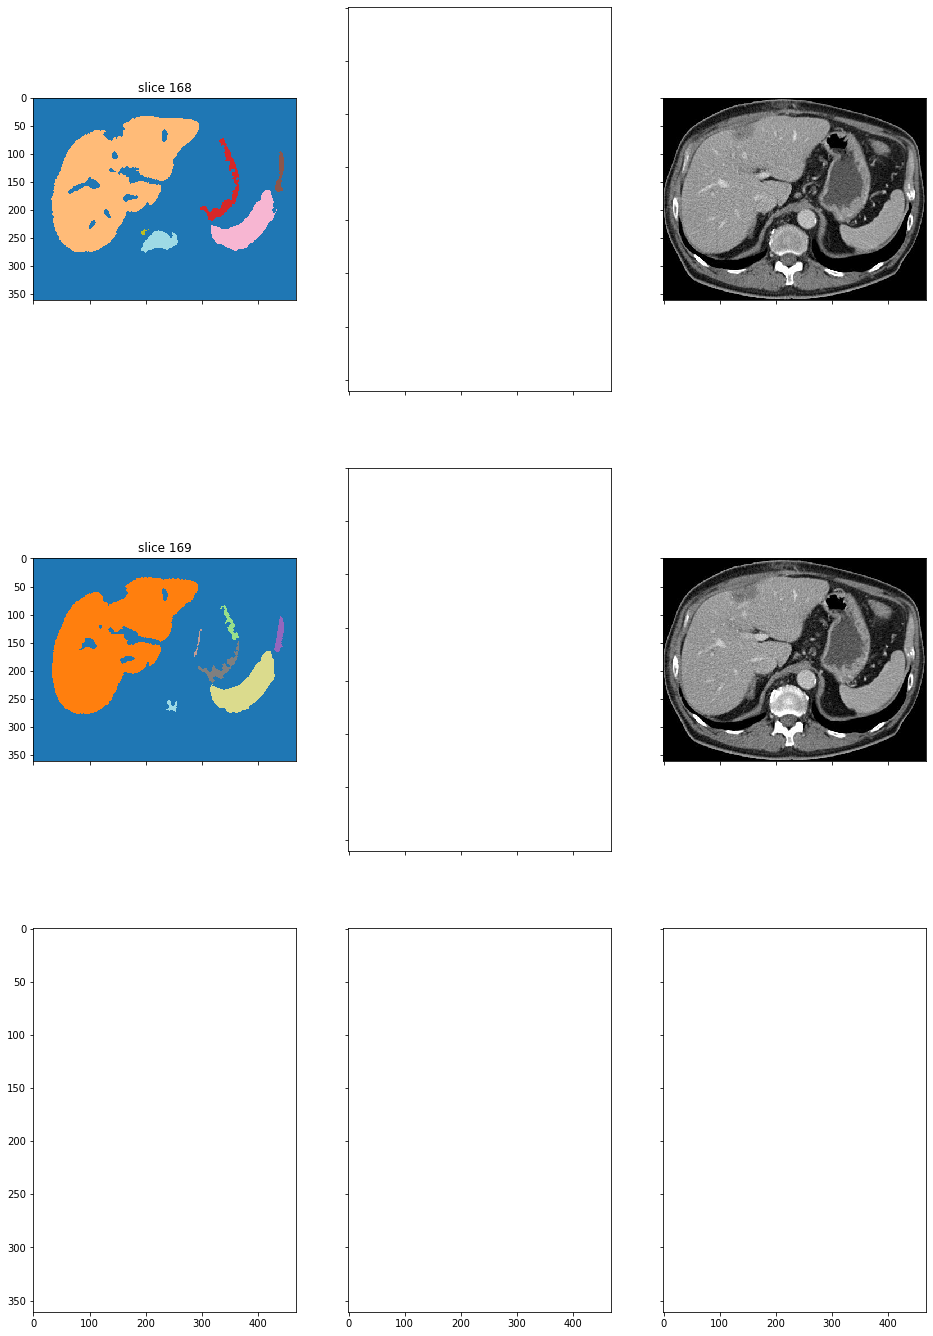

In [38]:
patients = {
    1: {"slice_idx":182, "bones_thresh": [170, 2, 64],
        "blood_vessels_thresh" : [158, 5, 64],
        "liver_thresh": [130, 1, 64],
       "reference_slide": 194}, #Enlarged spleen, 
    2: {"slice_idx":165, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh": [160, 5, 64], "liver_thresh": [125, 1, 64]},
    3: {"slice_idx":149, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh": [160, 5, 64], "liver_thresh": [125, 1, 64]},
    4: {"slice_idx":182, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [140, 1, 64]},
    5: {"slice_idx":155, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh": [170, 5, 64], "liver_thresh": [138, 1, 64]},
    7: {"slice_idx":166, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [140, 1, 64],
       "reference_slide": 168},
    8: {"slice_idx":186, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [165, 5, 64],
        "liver_thresh": [140, 1, 64]}, ## Slides 189 and 190 are corrupt (?)
    9: {"slice_idx":183, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [165, 5, 64],
        "liver_thresh": [125, 1, 64]},
    11: {"slice_idx":163, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [133, 1, 64]}, 
    12: {"slice_idx":175, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [125, 1, 64]}, # Really enlarged spleen
    13: {"slice_idx":165, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64], #Super cirrhotic liver + huge spleen
        "liver_thresh": [135, 1, 64], "reference_slice": 166},
    14: {"slice_idx":140, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64],
        "liver_thresh": [132, 1, 64],}, # Really large liver, hard to segment, really need to look into
                                        # bumping long dark areas
    16: {"slice_idx":190, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64],
        "liver_thresh": [120, 1, 64], "reference_slice": 166},
    40: {"slice_idx":150, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [125, 1, 64]},
    1001: {"slice_idx":170, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [170, 5, 64], "liver_thresh": [135, 1, 64]},
}

patients = {
    1: {"slice_idx":182, "bones_thresh": [170, 2, 64],
        "blood_vessels_thresh" : [158, 5, 64],
        "liver_thresh": [130, 1, 64],
       "reference_slide": 194}, #Enlarged spleen, 
    2: {"slice_idx":165, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh": [160, 5, 64], "liver_thresh": [125, 1, 64]},
    3: {"slice_idx":149, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh": [160, 5, 64], "liver_thresh": [125, 1, 64]},
    4: {"slice_idx":182, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [140, 1, 64]},
    5: {"slice_idx":155, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh": [170, 5, 64], "liver_thresh": [138, 1, 64]},
    7: {"slice_idx":168, "bones_thresh": [200, 2, 64],  # was 166
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [140, 1, 64],
       "reference_slide": 168},
    8: {"slice_idx":186, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [165, 5, 64],
        "liver_thresh": [140, 1, 64]}, ## Slides 189 and 190 are corrupt (?)
    9: {"slice_idx":183, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [165, 5, 64],
        "liver_thresh": [125, 1, 64]},
    11: {"slice_idx":163, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [133, 1, 64]}, 
    12: {"slice_idx":175, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [170, 5, 64],
        "liver_thresh": [125, 1, 64]}, # Really enlarged spleen
    13: {"slice_idx":165, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64], #Super cirrhotic liver + huge spleen
        "liver_thresh": [135, 1, 64], "reference_slice": 166},
    14: {"slice_idx":140, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64],
        "liver_thresh": [132, 1, 64],}, # Really large liver, hard to segment, really need to look into
                                        # bumping long dark areas
    16: {"slice_idx":190, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64],
        "liver_thresh": [120, 1, 64], "reference_slice": 166},
    17: {"slice_idx":190, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64],
        "liver_thresh": [120, 1, 64], "reference_slice": 166},  #Extremely awful liver
    18: {"slice_idx":180, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64],
        "liver_thresh": [120, 1, 64], "reference_slice": 166}, #lots of nonexistent slices
    19: {"slice_idx":190, "bones_thresh": [200, 2, 64],
        "blood_vessels_thresh" : [175, 5, 64],
        "liver_thresh": [120, 1, 64], "reference_slice": 166},
    40: {"slice_idx":150, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [122, 1, 64]},
    1001: {"slice_idx":170, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [170, 5, 64], "liver_thresh": [135, 1, 64]},
    45: {"slice_idx":210, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [122, 1, 64]}, #only outer borders of liver, treshold adjuustment does not help
    46: {"slice_idx":110, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [130, 1, 64]}, # treshold >128 heart not included
    46: {"slice_idx":95, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [130, 1, 64]}, # reference slice 97   
    48: {"slice_idx":212, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [170, 5, 64], "liver_thresh": [132, 1, 64]}, #slice 213 reference, slice 215 running out in adjacent stomach 
    48: {"slice_idx":180, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [130, 1, 64]}, #good sparing of portal vein on slice 181, but not on 183 and below
    46: {"slice_idx":65, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [130, 1, 64]}, #slice 78+79 medial part of liver different color
    49: {"slice_idx":160, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [165, 5, 64], "liver_thresh": [130, 1, 64]},
    49: {"slice_idx":180, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [165, 5, 64], "liver_thresh": [130, 1, 64]}, #reference slice 181 (minimal ribs included)
    50: {"slice_idx":185, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [170, 5, 64], "liver_thresh": [130, 1, 64]}, #right + left lobe divided
    50: {"slice_idx":205, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [170, 5, 64], "liver_thresh": [130, 1, 64]}, # reference slice 208
    51: {"slice_idx":210, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [135, 1, 64]}, # reference slice 213
    51: {"slice_idx":212, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [135, 1, 64]}, #slice 222: liver tresh 130, slice 212 liver tresh 135, reference slice 216
    51: {"slice_idx":208, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [135, 1, 64]}, # slice 212: right + left lobe divided
    52: {"slice_idx":190, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [150, 5, 64], "liver_thresh": [130, 1, 64]}, #inhomogeneous liver, blood 150 better
    52: {"slice_idx":158, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [155, 5, 64], "liver_thresh": [130, 1, 64]}, #reference slice 160, minimal vena cava
    55: {"slice_idx":200, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [130, 1, 64]}, #kissing sign liver + spleen
    56: {"slice_idx":197, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [130, 1, 64]}, #reference slice 200
    57: {"slice_idx":165, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [130, 1, 64]}, #reference slice 178, below slice 160 right + left lobe divided
    58: {"slice_idx":190, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [115, 1, 64]}, #hypodense liver, incomplete segmentation
    59: {"slice_idx":370, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [190, 5, 64], "liver_thresh": [120, 1, 64]}, #reference slice 372
    59: {"slice_idx":410, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [190, 5, 64], "liver_thresh": [160, 1, 64]}, #high tresh blood and liver for segmentation of liver
    60: {"slice_idx":210, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [137, 1, 64]}, #reference slice 212
    60: {"slice_idx":190, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [135, 1, 64]}, #slice 193 portal vein included, but below and above not
    61: {"slice_idx":210, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [175, 5, 64], "liver_thresh": [130, 1, 64]}, #intrahepatic collaterals
    61: {"slice_idx":180, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [175, 5, 64], "liver_thresh": [135, 1, 64]}, #reference slice 182
    64: {"slice_idx":199, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [170, 5, 64], "liver_thresh": [130, 1, 64]}, #minimal dorsal edge of right lobe missing
    64: {"slice_idx":190, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [130, 1, 64]},
    1001: {"slice_idx":190, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [170, 5, 64], "liver_thresh": [148, 1, 64]}, #minor running in adjacent heart
    1001: {"slice_idx":150, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [170, 5, 64], "liver_thresh": [148, 1, 64]}, #reference slice 179
    1002: {"slice_idx":190, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [170, 5, 64], "liver_thresh": [135, 1, 64]}, #running in stomach and anterior rib cartilage
    1002: {"slice_idx":210, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [175, 5, 64], "liver_thresh": [130, 1, 64]}, #running into stomach
    1003: {"slice_idx":180, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [165, 5, 64], "liver_thresh": [125, 1, 64]}, #vessels great excluded, running in rib cartilage, reference slice 183
    1004: {"slice_idx":205, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [165, 5, 64], "liver_thresh": [130, 1, 64]}, #great separation from diaphragm and vena cava
    1004: {"slice_idx":195, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [175, 5, 64], "liver_thresh": [130, 1, 64]}, #blurred borders of liver to intercostal space
    1005: {"slice_idx":490, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [175, 5, 64], "liver_thresh": [115, 1, 64]}, #reference slice 494
    1005: {"slice_idx":474, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [175, 5, 64], "liver_thresh": [140, 1, 64]}, #different treshold liver, then perfect separation from spleen
    1005: {"slice_idx":395, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [178, 5, 64], "liver_thresh": [145, 1, 64]}, #minimal ribs included
    1006: {"slice_idx":196, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [155, 5, 64], "liver_thresh": [125, 1, 64]},
    1006: {"slice_idx":190, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [160, 5, 64], "liver_thresh": [125, 1, 64]}, #reference slice 191
    1007: {"slice_idx":200, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [180, 5, 64], "liver_thresh": [135, 1, 64]}, #reference slice 203
    1007: {"slice_idx":182, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [180, 5, 64], "liver_thresh": [140, 1, 64]}, #liver treshold to 140, otherwise running in stomach, reference 183
    1008: {"slice_idx":430, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [165, 5, 64], "liver_thresh": [140, 1, 64]}, #reference 464, below 430 running in pancreas
    1009: {"slice_idx":159, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [165, 5, 64], "liver_thresh": [135, 1, 64]}, #running in stomach, in liver great
    1009: {"slice_idx":133, "bones_thresh": [200, 2, 64],
         "blood_vessels_thresh" : [165, 5, 64], "liver_thresh": [130, 1, 64]}}



importlib.reload(dicom_utils)
# Set these parameters
patient = 7
patient_id = patient
pt = patients[patient]

slice_idx = pt["slice_idx"]
slice_interval = 1
num_slices = 3
print(os.getcwd())

fig, axes = plt.subplots(num_slices, 3, figsize=(16, num_slices * 8), sharey=True, sharex=True)
try:
    os.mkdir(os.path.join(os.getcwd(), "assets/masked_images", str(patient_id)))
except:
    pass

# Optionally, also set these.
bones_thresh = pt["bones_thresh"]
blood_vessels_thresh = pt["blood_vessels_thresh"]
#blood_vessels_thresh = [160, 5, 64]
liver_thresh = pt["liver_thresh"]

livers = [None] * num_slices
regions = [None] * num_slices
have_ref = False
reference_liver = None
# Probably better not to mess with anything below this.

for i in range(num_slices):
    
    img_path = "assets/niftynet_raw_images/%d/%d.jpg" % (patient, slice_idx - i)
    img = skio.imread(img_path)
    #img = img.copy()
    axes[i, 2].imshow(img, cmap=plt.cm.gray)
    #dicom_utils.show_scan(img)
    mask = dicom_utils.partition_at_threshold(img, *bones_thresh, title="Bones", show_plot=False)
    imgb = img.copy() * (1 - mask)
    mask = dicom_utils.partition_at_threshold(imgb, *blood_vessels_thresh, title="Blood vessels", show_plot=False)
    imgb = imgb * (1 - mask)
    liver = dicom_utils.partition_at_threshold(imgb, *liver_thresh, title = "Organs/Liver", show_plot=False)
    edge_sobel = feature.canny(img, sigma=3)
    edge_sobel[liver == 0] = 0
    distance = ndi.distance_transform_edt(np.logical_not(edge_sobel))
    #mask = np.zeros_like(distance)
    #mask[distance <= 2] = 1
    liver[distance <= 1] = 0
    mask = liver > 0
    remove_small_objects(mask, in_place=True)
    liver[mask==0] = 0
    livers[i] = label(liver)

    #livers[i] = try_slice(liver)

    axes[i, 0].imshow(livers[i], cmap=plt.cm.tab20)
    #plt.savefig("assets/masked_images/" + str(patient_id) + "/" + str(slice_idx + i) + ".png", format="png")
    #dicom_utils.print_img(livers[i], "assets/masked_images/" + str(patient_id) + "/" + str(slice_idx + i))
    axes[i, 0].set_title('slice ' + str(slice_idx + i))

    # For each object, see which objects (on either side) it overlaps at least 50%.
    # if it overlaps just one object, then just check that the boundary is pretty skinny
    # If it overlaps two objects (ABOVE N SIZE??), divide it between them watershed.
    # Any skinny connector between them gets removed.

    if have_ref:
        newliver = guess_bounds_4(livers[i], reference_liver)
        display_liver = np.zeros([newliver.shape[0], newliver.shape[1], 4])
        #display_liver[:,:,3] = 0.99
        for row in range(newliver.shape[0]):
            for col in range(newliver.shape[1]):
                if newliver[row, col] > 0:
                    display_liver[row, col] = RGB_tuples[newliver[row, col] - 1] + [0.2]
        print("mmean", display_liver[:,:,3].mean())
        display_liver = display_liver*255
        display_liver = display_liver.astype(np.uint8)
        print("mmean", display_liver[:,:,3].mean())
        
        livers[i] = newliver

        if False:
            for il in range(26):
                newliver[il*20+1, :] = 100
                newliver[il*20, :] = 100
                newliver[:,il*20] = 100
                newliver[:,il*20+1] = 100
        for j in range(20):
            newliver[0:10,10*j:10*j+10] = j
        axes[i, 1].imshow(label2rgb(newliver, bg_label=0, colors=RGB_tuples, image=img/256))
        dicom_utils.mask_img(img, display_liver, "assets/masked_images/" + str(patient_id) + "/" + str(slice_idx + i))
    if mask.sum() > 1000:
        print("have ref")
        have_ref = True
        reference_liver = livers[i]

        
    #if i < num_slices - 1:
    #    newliver = guess_bounds_1(livers[i], livers[i+1])
    #    axes[i, 2].imshow(newliver, cmap=plt.cm.nipy_spectral)


In [7]:
patients
import json
mypats = json.dumps(patients)
mypats
with open("/Users/eiofinova/niftynet/thresholds.json", 'w') as file:
    file.write(mypats)

[189, 162, 176, 176, 162, 189, 228, 214, 200, 228, 200, 214, 215, 201, 229, 201, 215, 229, 188, 163, 177, 177, 163, 188, 149, 175, 161, 149, 161, 175, 203, 217, 217, 203, 202, 216, 216, 202, 174, 160, 148, 160, 174, 148, 170, 164, 158, 164, 170, 158, 206, 212, 212, 206, 207, 213, 213, 207, 159, 171, 165, 159, 165, 171, 198, 167, 173, 173, 167, 198, 211, 205, 239, 205, 211, 239, 238, 210, 204, 238, 204, 210, 199, 166, 172, 172, 166, 199, 138, 138, 139, 139, 134, 134, 242, 242, 243, 243, 135, 135, 137, 137, 241, 241, 240, 240, 136, 136, 132, 132, 133, 133, 180, 194, 143, 157, 157, 143, 194, 180, 209, 235, 221, 209, 221, 235, 234, 220, 208, 220, 234, 208, 181, 195, 142, 156, 156, 142, 195, 181, 197, 183, 168, 154, 140, 168, 140, 154, 183, 197, 222, 236, 236, 222, 223, 237, 237, 223, 196, 182, 155, 141, 169, 141, 155, 169, 182, 196, 192, 186, 151, 145, 179, 145, 151, 179, 186, 192, 227, 233, 233, 227, 226, 232, 232, 226, 193, 187, 178, 150, 144, 178, 144, 150, 187, 193, 185, 191, 146, 152,

KeyboardInterrupt: 

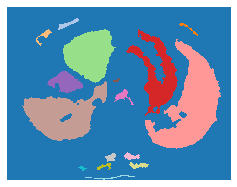

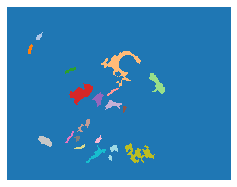

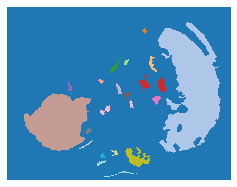

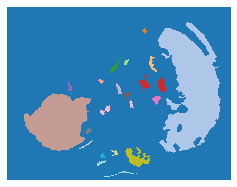

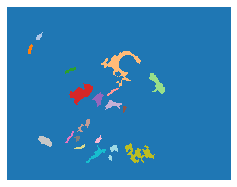

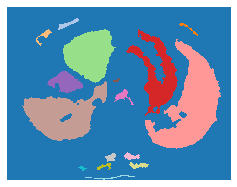

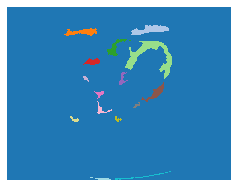

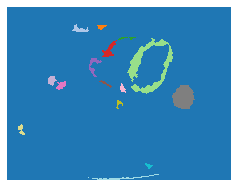

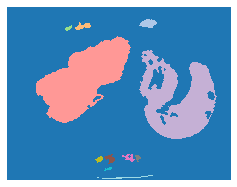

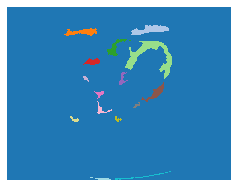

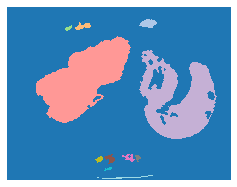

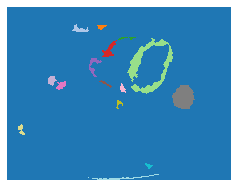

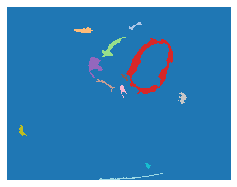

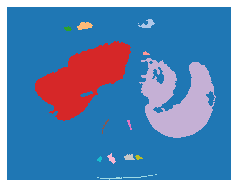

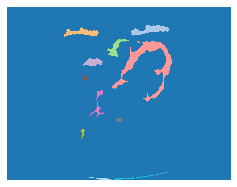

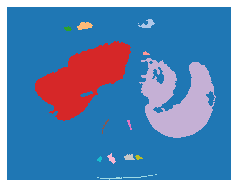

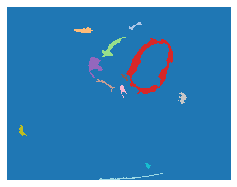

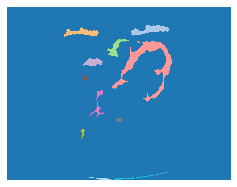

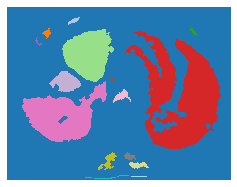

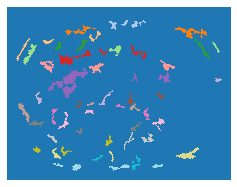

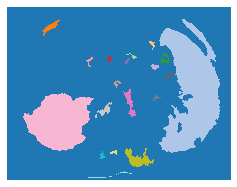

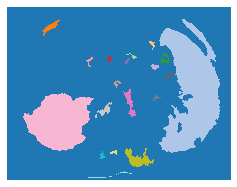

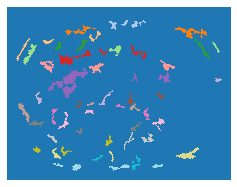

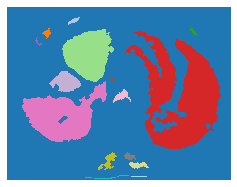

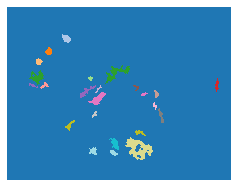

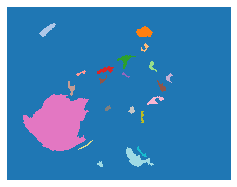

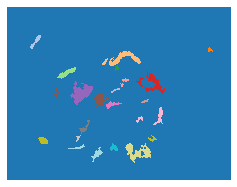

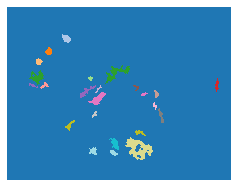

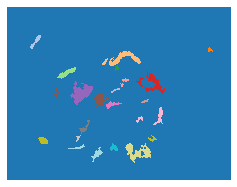

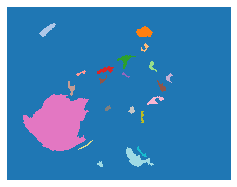

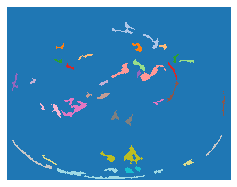

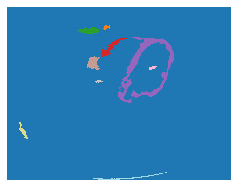

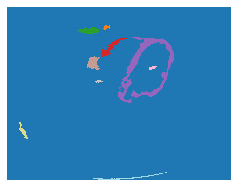

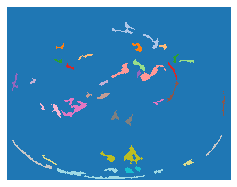

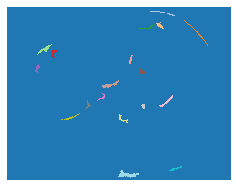

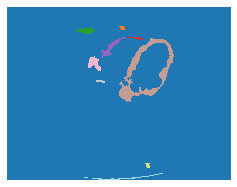

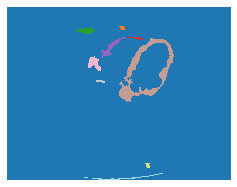

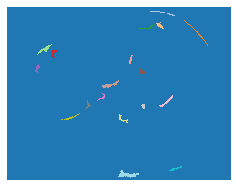

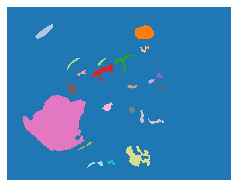

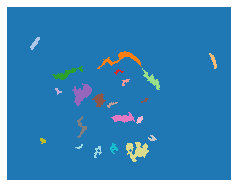

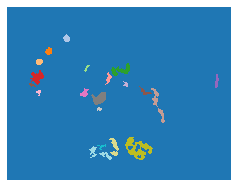

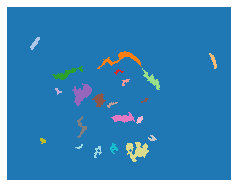

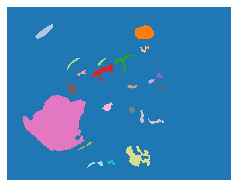

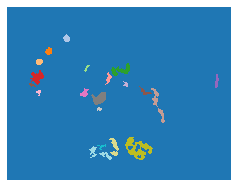

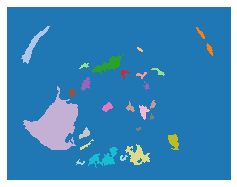

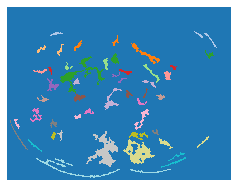

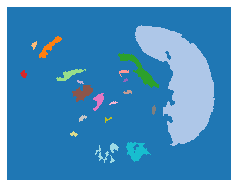

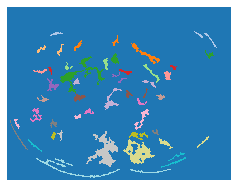

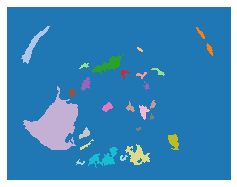

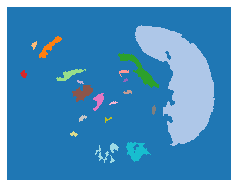

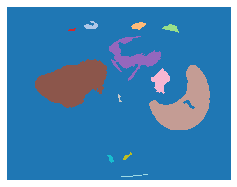

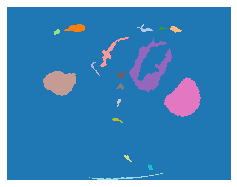

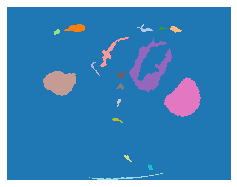

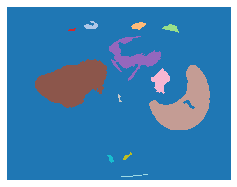

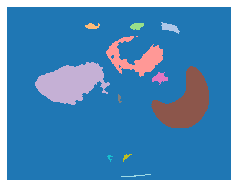

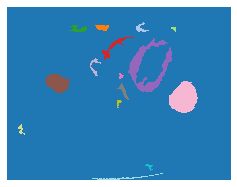

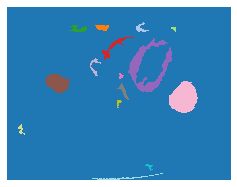

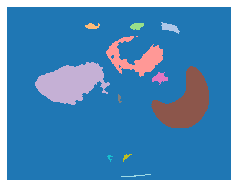

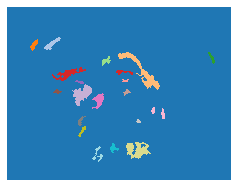

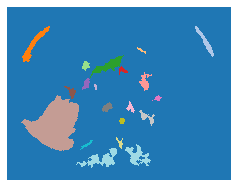

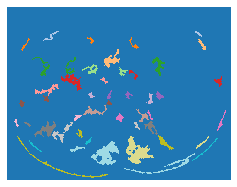

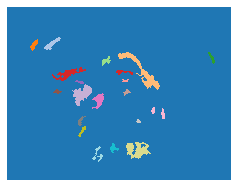

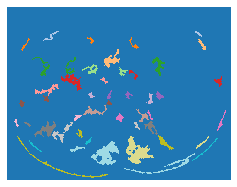

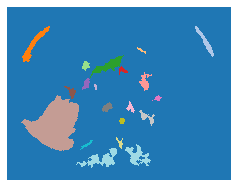

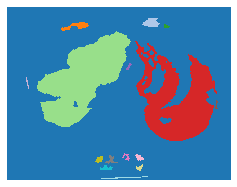

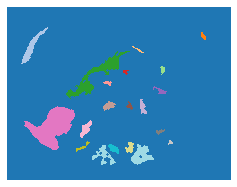

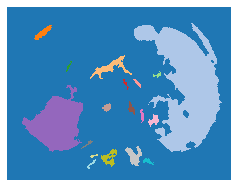

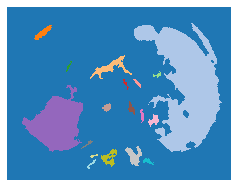

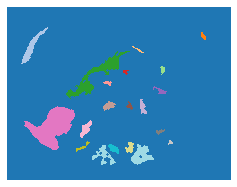

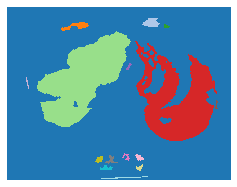

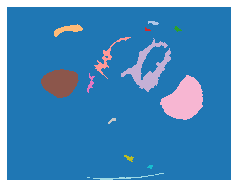

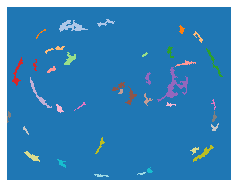

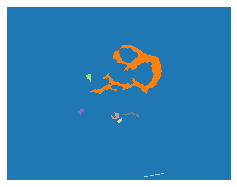

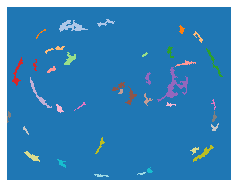

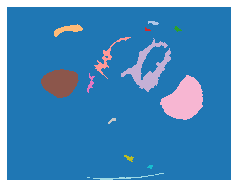

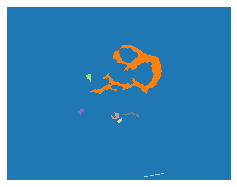

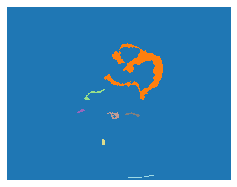

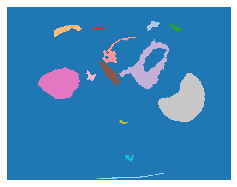

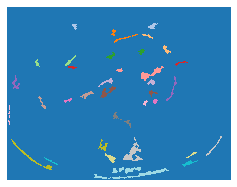

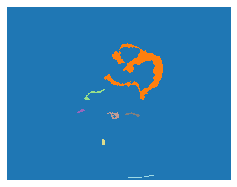

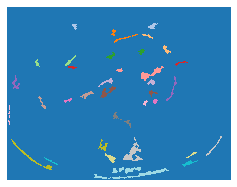

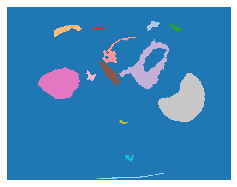

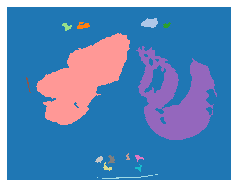

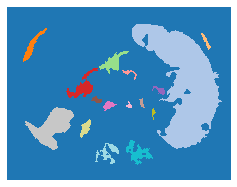

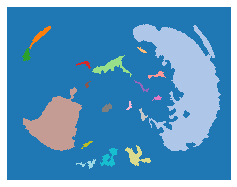

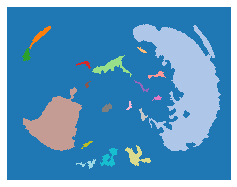

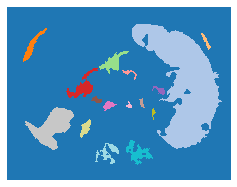

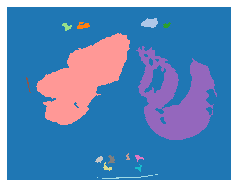

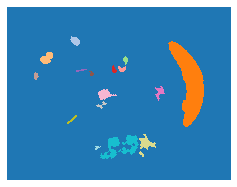

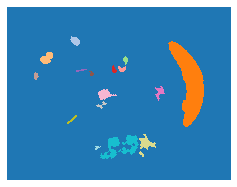

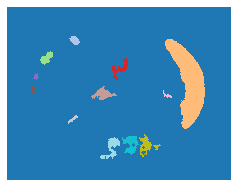

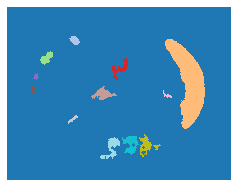

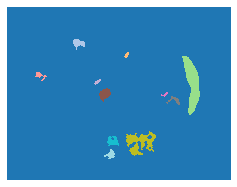

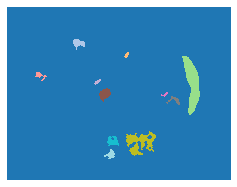

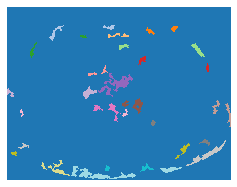

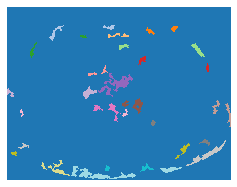

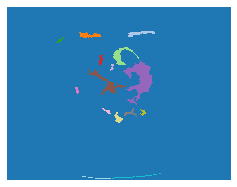

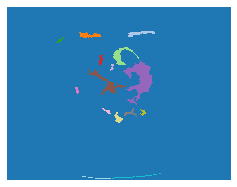

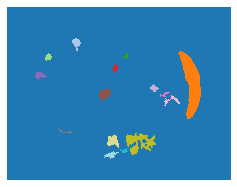

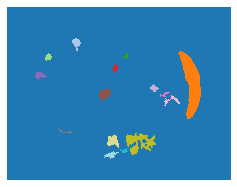

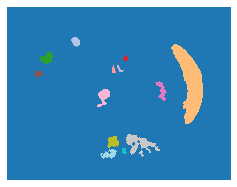

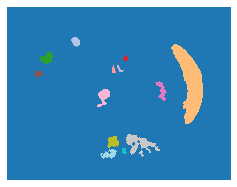

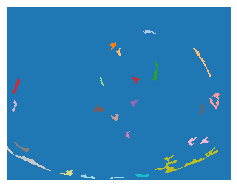

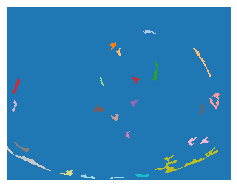

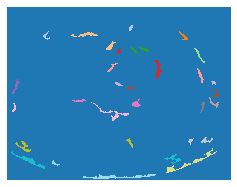

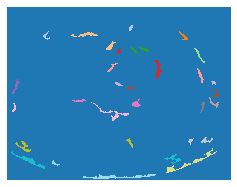

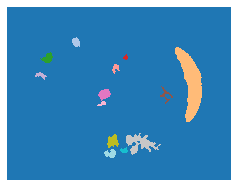

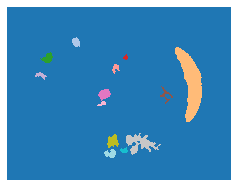

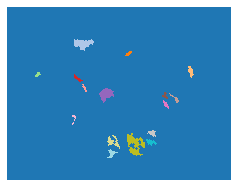

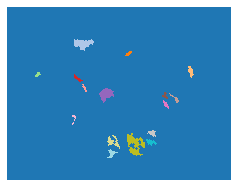

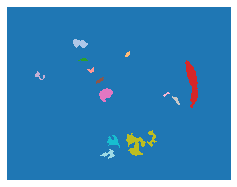

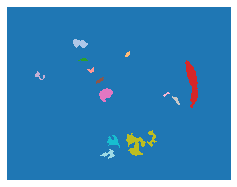

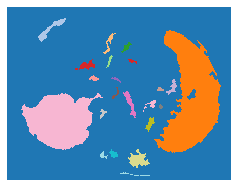

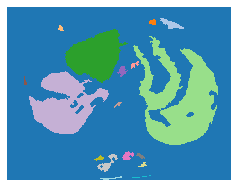

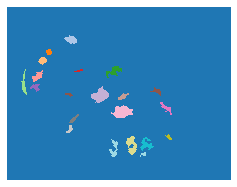

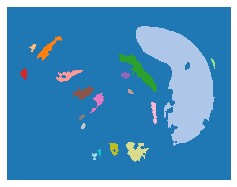

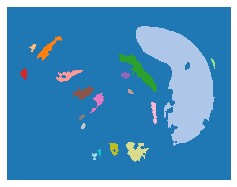

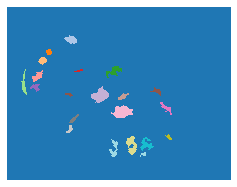

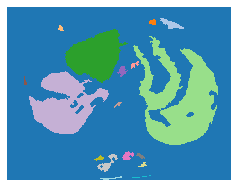

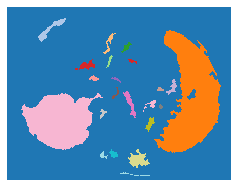

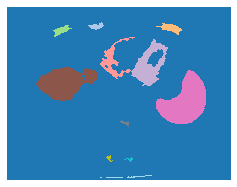

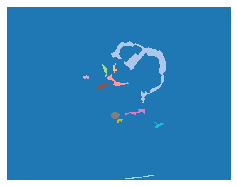

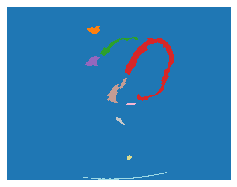

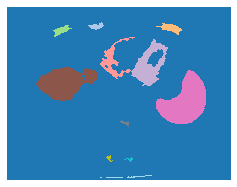

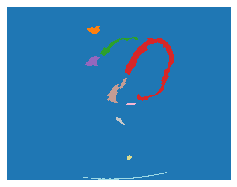

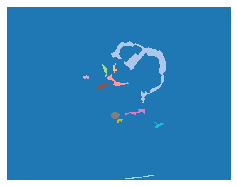

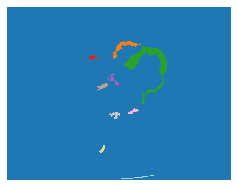

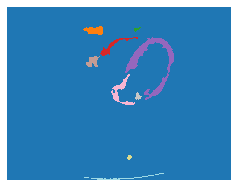

In [42]:
#!mkdir -p {"assets/niftynet_raw_images/%d" % 13}
#patient_id = 14
for patient_id in patients.keys():
    pt = patients[patient_id]
    bones_thresh = [200, 2, 64]
    blood_vessels_thresh = pt["blood_vessels_thresh"]
    liver_thresh = pt["liver_thresh"]

    file_dir = os.path.join(os.getcwd(), "assets", "niftynet_raw_images", str(patient_id))
    os.makedirs(os.path.join(os.getcwd(), "assets", "raw_masks", str(patient_id)), exist_ok = True)
    slices = [int(x.split(".")[0]) for x in os.listdir(file_dir)]
    print(slices)

    for slice in slices:
        img_path = "assets/niftynet_raw_images/%d/%d.png" % (patient_id, slice)
        img = skio.imread(img_path)
        axes[0, 0].imshow(img, cmap=plt.cm.gray)
        mask = dicom_utils.partition_at_threshold(img, *bones_thresh, title="Bones", show_plot=False)
        imgb = img.copy() * (1 - mask)
        mask = dicom_utils.partition_at_threshold(imgb, *blood_vessels_thresh, title="Blood vessels", show_plot=False)
        imgb = imgb * (1 - mask)
        liver = dicom_utils.partition_at_threshold(imgb, *liver_thresh, title = "Organs/Liver", show_plot=False)
        edge_sobel = feature.canny(img, sigma=3)
        edge_sobel[liver == 0] = 0
        distance = ndi.distance_transform_edt(np.logical_not(edge_sobel))
        #mask = np.zeros_like(distance)
        #mask[distance <= 2] = 1
        liver[distance <= 1] = 0
        mask = liver > 0
        remove_small_objects(mask, in_place=True)
        liver[mask==0] = 0
        liver = label(liver)
        dicom_utils.print_img(liver, "assets/raw_masks/%d/%d" % (patient_id, slice))

In [9]:
patients = [20, 21, 22, 23]
importlib.reload(dicom_utils)
#!mkdir -p {"assets/niftynet_raw_images/%d" % 13}
#patient_id = 14
#for patient_id in patients.keys():
for patient_id in patients:
    #patient_id = 7
    print(patient_id)
    #pt = patients[patient_id]
    #print(pt)
    bones_thresh = [200, 2, 64]
    blood_vessels_thresh = [165, 5, 64]
    liver_thresh = [130, 1, 64]

    file_dir = os.path.join(os.getcwd(), "assets", "niftynet_raw_images", str(patient_id))
    os.makedirs(os.path.join(os.getcwd(), "assets", "masks2", str(patient_id)), exist_ok = True)
    slices = [int(x.split(".")[0]) for x in os.listdir(file_dir)]

    for slice in slices:
        img_path = "assets/niftynet_raw_images/%d/%d.png" % (patient_id, slice)
        img = skio.imread(img_path)
        #axes[0, 0].imshow(img, cmap=plt.cm.gray)
        mask = dicom_utils.partition_at_threshold(img, *bones_thresh, title="Bones", show_plot=False)
        imgb = img.copy() * (1 - mask)
        mask = dicom_utils.partition_at_threshold(imgb, *blood_vessels_thresh, title="Blood vessels", show_plot=False)
        imgb = imgb * (1 - mask)
        liver = dicom_utils.partition_at_threshold(imgb, *liver_thresh, title = "Organs/Liver", show_plot=False)
        edge_sobel = feature.canny(img, sigma=3)
        edge_sobel[liver == 0] = 0
        distance = ndi.distance_transform_edt(np.logical_not(edge_sobel))
        #mask = np.zeros_like(distance)
        #mask[distance <= 2] = 1
        liver[distance <= 1] = 0
        mask = liver > 0
        remove_small_objects(mask, in_place=True)
        liver[mask==0] = 0
        newliver = label(liver)
        newliver[newliver>0] = newliver[newliver>0] + 2
        #display_liver = np.zeros([newliver.shape[0], newliver.shape[1], 4])
        #display_liver[:,:,3] = 0.99
        #for row in range(newliver.shape[0]):
        #    for col in range(newliver.shape[1]):
        #        if newliver[row, col] > 0:
        #            display_liver[row, col] = RGB_tuples[newliver[row, col] - 1] + [0.2]
        #display_liver = display_liver*255
        #display_liver = display_liver.astype(np.uint8)
        #print(liver.shape)    

        #dicom_utils.mask_img(img, display_liver, "assets/masked_images/%d/%d" % (patient_id, slice))
        dicom_utils.save_partition(newliver, "assets/masks2/%d/%d" % (patient_id, slice))

30


In [25]:
def detect_questionable_slices(patient, kslice):
    mask = np.loadtxt("./assets/masks/%d/%s.txt" % (patient, slicex))
    if max([x.area for x in regionprops(label(mask))]) < 800:
        #print(patient, kslice)
        return True
    return False
    
quest_slices = {}
for patient in patients:
    try:
        slices = [x.split(".")[0] for x in os.listdir(os.path.join(os.getcwd(), "assets", "masks", str(patient)))]
        slices.sort()
        quest_slices[patient] = []
        for slicex in slices:
            if detect_questionable_slices(patient, slicex):
                quest_slices[patient].append(slicex)
    except Exception as e:
        print("Problem with patient ", patient, e)
    
    

    


    

Problem with patient  15 [Errno 2] No such file or directory: '/Users/eiofinova/niftynet/assets/masks/15'
Problem with patient  20 [Errno 2] No such file or directory: '/Users/eiofinova/niftynet/assets/masks/20'
Problem with patient  21 [Errno 2] No such file or directory: '/Users/eiofinova/niftynet/assets/masks/21'
Problem with patient  22 [Errno 2] No such file or directory: '/Users/eiofinova/niftynet/assets/masks/22'
Problem with patient  23 [Errno 2] No such file or directory: '/Users/eiofinova/niftynet/assets/masks/23'
Problem with patient  24 [Errno 2] No such file or directory: '/Users/eiofinova/niftynet/assets/masks/24'
Problem with patient  28 [Errno 2] No such file or directory: '/Users/eiofinova/niftynet/assets/masks/28'
Problem with patient  29 [Errno 2] No such file or directory: '/Users/eiofinova/niftynet/assets/masks/29'
Problem with patient  30 [Errno 2] No such file or directory: '/Users/eiofinova/niftynet/assets/masks/30'
Problem with patient  31 [Errno 2] No such fil

In [35]:
quest_slices

import json
with open("./questionable_slices.json", 'w') as f:
    json.dump(quest_slices, f)
    
! cat ./questionable_slices.json

{"1": ["202", "203", "204", "240", "241"], "2": ["211"], "3": [], "4": ["125", "126", "127"], "5": ["191", "192", "208", "211", "212"], "7": ["103", "104", "105", "106", "107", "108", "109", "110", "111", "112", "113", "114", "115", "120", "121"], "8": ["189", "190", "191", "192", "217", "219", "226", "227", "228", "229"], "9": [], "11": ["127"], "12": [], "13": [], "14": [], "16": [], "17": [], "18": [], "19": [], "40": ["210", "212", "223", "224", "225", "229", "230"], "45": ["100", "101", "105", "106", "107", "108", "109", "111", "115", "125", "126", "127", "128", "141", "216", "217", "82", "83", "84", "85", "86", "87", "88", "89", "90", "91", "92", "93", "94", "99"], "46": ["103", "17"], "48": [], "49": ["166", "194", "219", "221"], "50": [], "51": ["245", "246", "247", "248", "249", "250", "251", "252", "253"], "52": ["104", "105", "106", "107", "108", "109", "110", "111", "112", "113", "114", "115", "116", "117", "96", "98"], "55": [], "56": ["102", "103", "104", "107", "108", "1

## fig, axes = plt.subplots(2, 2, figsize=(16, 16), sharey=True, sharex=True)

bones_thresh = [200, 2, 64]
blood_vessels_thresh =  [175, 5, 64] #Super cirrhotic liver + huge spleen
liver_thresh =  [135, 1, 64]
print("hello")
img_path = "assets/niftynet_raw_images/%d/%d.jpg" % (13, 166)
img = skio.imread(img_path)
axes[0, 0].imshow(img, cmap=plt.cm.gray)
mask = dicom_utils.partition_at_threshold(img, *bones_thresh, title="Bones", show_plot=False)
imgb = img.copy() * (1 - mask)
mask = dicom_utils.partition_at_threshold(imgb, *blood_vessels_thresh, title="Blood vessels", show_plot=False)
imgb = imgb * (1 - mask)
liver = dicom_utils.partition_at_threshold(imgb, *liver_thresh, title = "Organs/Liver", show_plot=False)
axes[1, 0].imshow(liver, cmap=plt.cm.tab20)

#from skimage.filters.rank import enhance_contrast
#from skimage.filters.rank import autolevel
#from skimage.filters.rank import maximum, minimum, gradient
#from skimage.morphology import disk
print(img.mean())
mask = (img < 120) * 130
print(mask.mean())
#enh = gradient(img, disk(5))
#axes[0, 1].imshow(mask, cmap=plt.cm.gray)

from skimage import filters
from skimage import feature
edge_roberts = filters.roberts(img)
edge_sobel = feature.canny(img, sigma=3)
print(edge_sobel.mean())
#axes[0, 1].imshow(edge_roberts, cmap=plt.cm.gray)
axes[0, 1].imshow(edge_sobel, cmap=plt.cm.gray)

img[edge_sobel > 0.5] = 0
mask = dicom_utils.partition_at_threshold(img, *bones_thresh, title="Bones", show_plot=False)
imgb = img.copy() * (1 - mask)
mask = dicom_utils.partition_at_threshold(imgb, *blood_vessels_thresh, title="Blood vessels", show_plot=False)
imgb = imgb * (1 - mask)
liver = dicom_utils.partition_at_threshold(imgb, *liver_thresh, title = "Organs/Liver", show_plot=False)
axes[1, 1].imshow(liver, cmap=plt.cm.tab20)
    

hello
80.5272251462848
81.82404657590638
0.060695698197535945


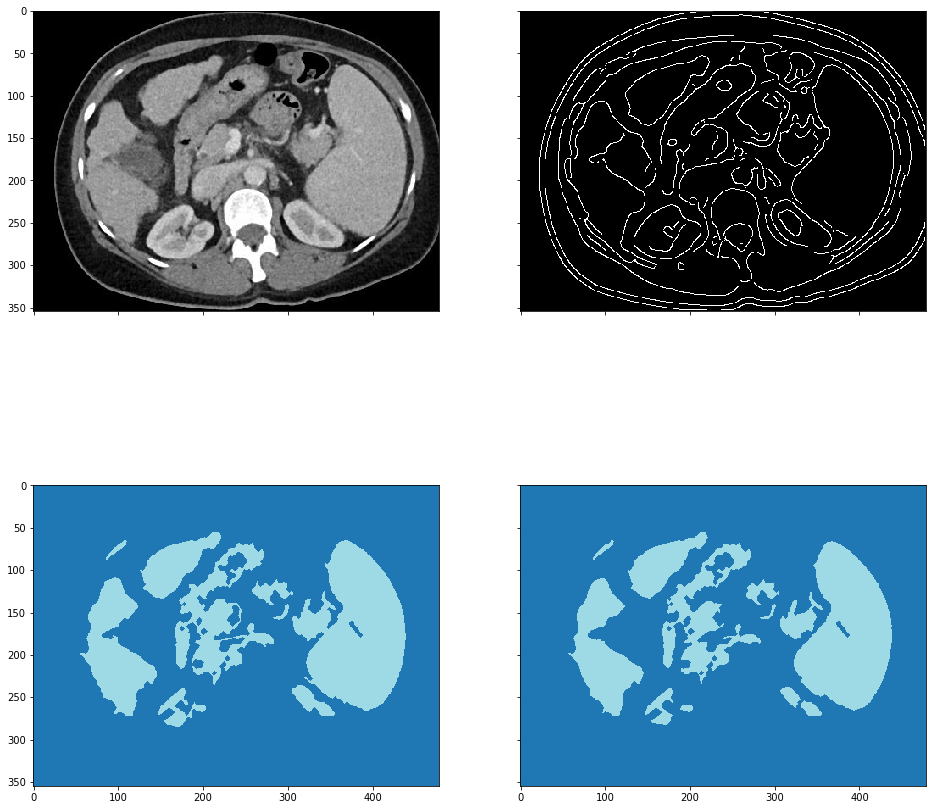

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16), sharey=True, sharex=True)

bones_thresh = [200, 2, 64]
blood_vessels_thresh =  [175, 5, 64] #Super cirrhotic liver + huge spleen
liver_thresh =  [135, 1, 64]
print("hello")
img_path = "assets/niftynet_raw_images/%d/%d.jpg" % (13, 166)
img = skio.imread(img_path)
axes[0, 0].imshow(img, cmap=plt.cm.gray)
mask = dicom_utils.partition_at_threshold(img, *bones_thresh, title="Bones", show_plot=False)
imgb = img.copy() * (1 - mask)
mask = dicom_utils.partition_at_threshold(imgb, *blood_vessels_thresh, title="Blood vessels", show_plot=False)
imgb = imgb * (1 - mask)
liver = dicom_utils.partition_at_threshold(imgb, *liver_thresh, title = "Organs/Liver", show_plot=False)
axes[1, 0].imshow(liver, cmap=plt.cm.tab20)

#from skimage.filters.rank import enhance_contrast
#from skimage.filters.rank import autolevel
#from skimage.filters.rank import maximum, minimum, gradient
#from skimage.morphology import disk
print(img.mean())
mask = (img < 120) * 130
print(mask.mean())
#enh = gradient(img, disk(5))
#axes[0, 1].imshow(mask, cmap=plt.cm.gray)

from skimage import filters
from skimage import feature
edge_roberts = filters.roberts(img)
edge_sobel = feature.canny(img, sigma=3)
print(edge_sobel.mean())
#axes[0, 1].imshow(edge_roberts, cmap=plt.cm.gray)
axes[0, 1].imshow(edge_sobel, cmap=plt.cm.gray)

img[edge_sobel > 0.5] = 0
mask = dicom_utils.partition_at_threshold(img, *bones_thresh, title="Bones", show_plot=False)
imgb = img.copy() * (1 - mask)
mask = dicom_utils.partition_at_threshold(imgb, *blood_vessels_thresh, title="Blood vessels", show_plot=False)
imgb = imgb * (1 - mask)
liver = dicom_utils.partition_at_threshold(imgb, *liver_thresh, title = "Organs/Liver", show_plot=False)
axes[1, 1].imshow(liver, cmap=plt.cm.tab20)
    

In [10]:
import csv

with open("/Users/eiofinova/niftynet/Patient_List_18_3_20.csv") as csvfile:
    patients = csv.reader(csvfile, delimiter=";")
    for row in patients:
        print(row)

['\ufeffID', '1=m, 2=f', 'Age group', 'HVPG group', '', '', '', '']
['1', '1', '2', '3', '', '', '', '']
['2', '1', '2', '2', '', '', '', '']
['3', '1', '3', '4', '', '', '', '']
['4', '1', '3', '2', '', '', '', '']
['5', '1', '1', '2', '', '', '', '']
['6', '1', '2', '2', '', '', '', '']
['7', '1', '3', '1', '', '', '', '']
['8', '1', '3', '1', '', '', '', '']
['9', '1', '3', '4', '', '', '', '']
['10', '1', '2', '5', '', '', '', '']
['11', '1', '2', '5', '', '', '', '']
['12', '1', '2', '3', '', '', '', '']
['13', '2', '2', '5', '', '', '', '']
['15', '1', '2', '5', '', '', '', '']
['16', '1', '3', '1', '', '', '', '']
['17', '1', '1', '0', '', '', '', '']
['18', '1', '2', '4', '', '', '', '']
['19', '1', '3', '5', '', '', '', '']
['20', '1', '2', '4', '', '', '', '']
['21', '2', '3', '4', '', '', '', '']
['22', '1', '3', '1', '', '', '', '']
['23', '1', '3', '1', '', '', '', '']
['24', '1', '2', '4', '', '', '', '']
['25', '1', '3', '2', '', '', '', '']
['26', '1', '2', '5', '', '',

In [29]:
import pandas as pd
patients = pd.read_csv("/Users/eiofinova/niftynet/Patient_List_18_3_20.csv", delimiter=";")
patients = patients[patients.ID > 0]
patients = patients[patients["HVPG group"] > 0]
patients = patients[["ID", "1=m, 2=f", "Age group", "HVPG group", "CT group"]]
patients.rename(columns={"1=m, 2=f":"sex", "Age group":"age", "HVPG group":"hvpg", "CT group": 'ct'}, inplace=True)
patients["ID"] = patients.ID.astype(int)
patients

,ID,sex,age,hvpg,ct
0,1,1,2.0,3.0,1.0
1,2,1,2.0,2.0,1.0
2,3,1,3.0,4.0,1.0
3,4,1,3.0,2.0,4.0
4,5,1,1.0,2.0,1.0
...,...,...,...,...,...
446,469,1,2.0,5.0,2.0
447,470,1,3.0,5.0,2.0
448,471,1,3.0,4.0,1.0
449,472,2,3.0,3.0,7.0


In [30]:
df_ = patients.groupby(["sex", "age", "hvpg", "ct"]).apply(lambda x: (x.ID.astype(str)).str.
                                                     cat(sep=","))

In [31]:
#df_.index = df_.index.droplevel([0, 1])
df_

sex  age  hvpg  ct 
     3.0  4.0   4.0         57
1    1.0  1.0   1.0        150
                2.0    417,459
          2.0   1.0      5,167
                2.0         55
                        ...   
2    3.0  5.0   4.0        104
                7.0         37
     4.0  1.0   2.0        344
          4.0   2.0        303
          5.0   2.0         68
Length: 99, dtype: object

In [32]:
patients.count()

ID      441
sex     439
age     441
hvpg    441
ct      441
dtype: int64

In [33]:
df_.count()

99

In [34]:
452*0.3

135.6

In [35]:
already_used = {x for x in range(65)} - {10, 47, 53, 63}

In [63]:
import random
test = set()
train = set()

for row in df_.values:
    ids = {int(x) for x in row.split(",")}
    print(ids)
    def_test = ids.intersection(already_used)
    randoms = [1 if x in already_used else random.random() for x in ids]
    #print(randoms)
    cutoff = np.percentile(randoms, 25)
    print(cutoff)
    test = test.union({x for i, x in enumerate(ids) if randoms[i] < cutoff})
    train = train.union({x for i, x in enumerate(ids) if randoms[i] >= cutoff})
    
    

{57}
1.0
{150}
0.9853563042467153
{417, 459}
0.3661364595555916
{5, 167}
0.9051692282592352
{55}
1.0
{268}
0.9252956184382726
{44}
1.0
{160, 38, 399}
0.7478462530911171
{115, 317}
0.11999492700678085
{255, 78, 431, 211, 342, 411, 287}
0.21537150799203014
{355, 370, 83}
0.45152138334663866
{124}
0.03590788130886091
{283, 91}
0.44197679151070757
{288, 133, 166, 134, 232, 263, 461, 47, 145, 306, 278, 250}
0.17014431145035216
{286}
0.1406998348514079
{123}
0.9469533528026154
{2, 155}
0.7439034683122878
{6, 295, 201, 302, 208, 59}
0.46876703866719366
{219, 395}
0.2828362528429418
{1, 328, 108, 367, 177, 241}
0.5530436569486609
{224, 12, 102}
0.778393827940576
{294}
0.8677953930852508
{407, 33, 326, 136, 42, 18, 20, 149, 246, 404, 248, 412, 29, 95, 63}
0.20007317394961233
{130, 386, 388, 393, 138, 280, 24, 28, 421, 39, 296, 170, 183, 56, 311, 314, 61, 203, 205, 333, 207, 464, 209, 210, 341, 473, 98, 357, 359, 377, 110, 116, 244, 376, 121}
0.2793486761694739
{185}
0.5308515614066202
{360, 146

In [80]:
print(len(test))
print(len(train))

115
324


In [65]:
len(train.intersection(already_used))

54

In [66]:
len(already_used)

61

In [67]:
already_used - train

{0, 14, 17, 41, 49, 58, 62}

In [68]:
patients["test"] = [x in test for x in patients.ID]

In [69]:
ages = patients.groupby(['test', 'age']).size().unstack(fill_value=0)
hvpg = patients.groupby(['test', 'hvpg']).size().unstack(fill_value=0)
sex = patients.groupby(['test', 'sex']).size().unstack(fill_value=0)
ct = patients.groupby(['test', 'ct']).size().unstack(fill_value=0)

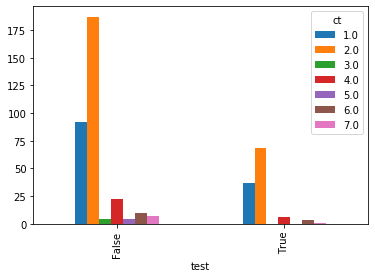

In [79]:
fig = ct.plot.bar();
fig.get_figure().savefig("/Users/eiofinova/niftynet/tt_ct.jpg")
fig

In [71]:
ct

ct,1.0,2.0,3.0,4.0,5.0,6.0,7.0
test,,,,,,,
False,92,187,4,22,4,10,7
True,37,68,0,6,0,3,1


In [81]:
patients.to_csv("/Users/eiofinova/niftynet/tt_split.csv", index=False)